# Import des librairies et chargement des données

In [2]:
import pandas as pd
import pandas as pd
import networkx as nx
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Patch
from networkx.algorithms import community as nx_community
from sklearn.cluster import SpectralClustering
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from collections import defaultdict, Counter
from community import community_louvain
from community import community_louvain
from sklearn.cluster import SpectralClustering
import community as community_louvain
from collections import defaultdict
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.linalg as la
import random
random.seed(42)


### 2. Chargement des données
Nous utilisons les données de contact de l'école primaire issues du projet SocioPatterns.  
Chaque ligne représente un contact (20s) entre deux individus (source, target) à un instant donné

In [3]:
# Lecture du fichier avec noms explicites
df = pd.read_csv(".\data\primaryschool.csv", names=["timestamp", "source", "target", "classe_source", "classe_target"],delimiter='\t')

# Affichage des 5 premières lignes
df.head()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\david\AppData\Local\Temp\ipykernel_38100\4023979897.py:2: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv(".\data\primaryschool.csv", names=["timestamp", "source", "target", "classe_source", "classe_target"],delimiter='\t')


,timestamp,source,target,classe_source,classe_target
0,31220,1558,1567,3B,3B
1,31220,1560,1570,3B,3B
2,31220,1567,1574,3B,3B
3,31220,1632,1818,4B,4B
4,31220,1632,1866,4B,4B


# construction du graphe

In [4]:
import networkx as nx

# Agrégation des poids (nombre de contacts entre chaque paire)
edge_weights = df.groupby(['source', 'target']).size().reset_index(name='weight')

# Initialisation du graphe
G = nx.Graph()

# Ajout des arêtes avec poids
for _, row in edge_weights.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

# Ajout des classes en attributs de nœud (en priorisant classe_source)
node_classes = df.groupby('source')['classe_source'].first().to_dict()
node_classes.update(df.groupby('target')['classe_target'].first().to_dict())

# Enregistrement des classes comme attributs
for node, classe in node_classes.items():
    G.nodes[node]['classe'] = classe


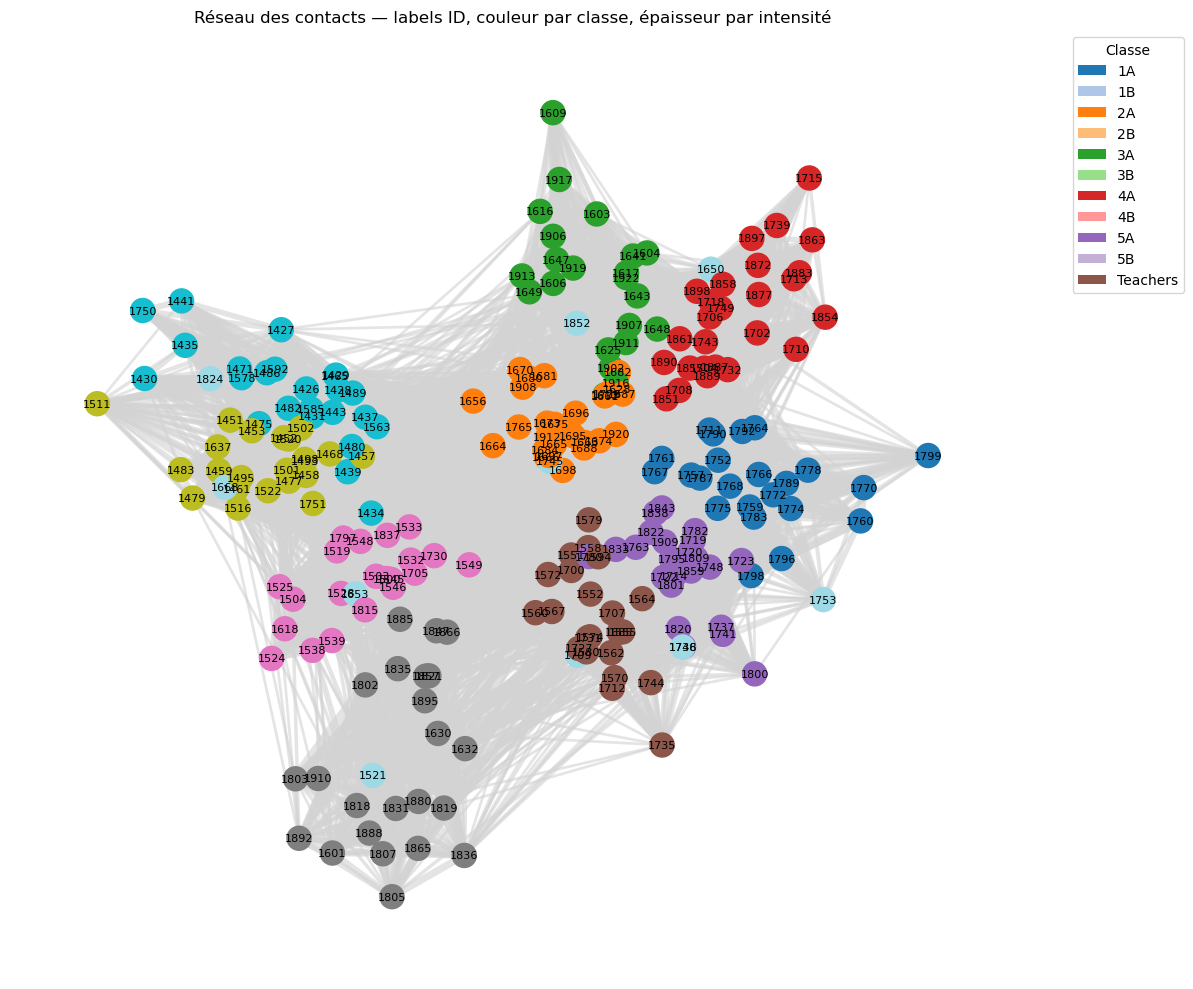

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# Position des nœuds
pos = nx.spring_layout(G, seed=42)

# Classes et couleurs
classes = nx.get_node_attributes(G, 'classe')
unique_classes = sorted(set(classes.values()))
class_color_map = {cls: i for i, cls in enumerate(unique_classes)}
node_colors = [class_color_map[classes[n]] for n in G.nodes()]

# Poids des arêtes pour l'épaisseur
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
min_w, max_w = min(edge_weights), max(edge_weights)

# Accentuation de la différence : transformation logarithmique douce
normalized_weights = [1 + 9 * (np.log(w + 1) / np.log(max_w + 1)) for w in edge_weights]

# Création du graphe
plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G, pos, width=normalized_weights, edge_color='lightgray', alpha=0.6)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab20, node_size=300)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Réseau des contacts — labels ID, couleur par classe, épaisseur par intensité")
plt.axis("off")

# Légende des classes
legend_elements = [Patch(facecolor=plt.cm.tab20(class_color_map[cls]/20), label=cls) for cls in unique_classes]
plt.legend(handles=legend_elements, title="Classe", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# Analyse structurelle

In [6]:
N = G.number_of_nodes()
M = G.number_of_edges()
density = nx.density(G)

print(f"Nombre de nœuds : {N}")
print(f"Nombre d'arêtes : {M}")
print(f"Densité du graphe : {density:.4f}")


Nombre de nœuds : 242
Nombre d'arêtes : 8317
Densité du graphe : 0.2852


La faible densité du réseau indique que chaque individu n’interagit qu’avec une fraction limitée de la population scolaire. Malgré cela, la présence d’une connectivité globale permet une propagation potentiellement rapide des maladies.

## distribution des degrés

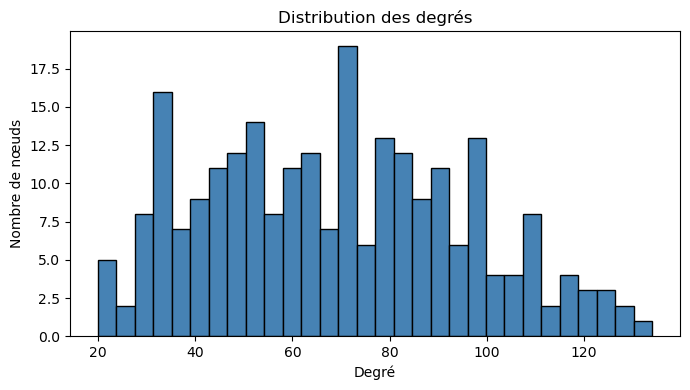

In [7]:
degrees = [d for _, d in G.degree()]

plt.figure(figsize=(7,4))
plt.hist(degrees, bins=30, color='steelblue', edgecolor='black')
plt.xlabel("Degré")
plt.ylabel("Nombre de nœuds")
plt.title("Distribution des degrés")
plt.tight_layout()
plt.show()


La distribution des degrés est hétérogène, ce qui signifie que certains élèves ou enseignants interagissent avec un grand nombre de personnes. Ces nœuds peuvent jouer un rôle clé dans la diffusion d’une épidémie.

## composants connexes

Nombre de composantes connexes : 1
Taille de la plus grande composante : 242


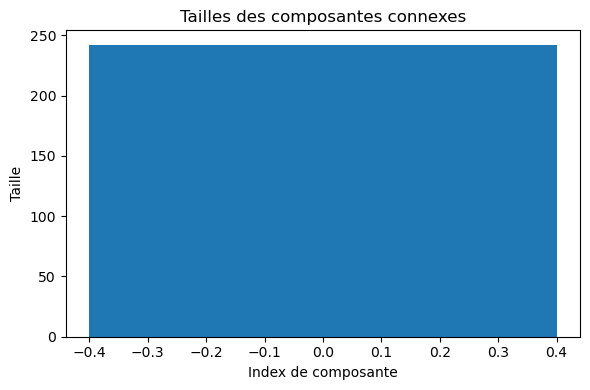

In [8]:
components = list(nx.connected_components(G))
component_sizes = sorted([len(c) for c in components], reverse=True)

print(f"Nombre de composantes connexes : {len(components)}")
print(f"Taille de la plus grande composante : {component_sizes[0]}")

plt.figure(figsize=(6,4))
plt.bar(range(len(component_sizes)), component_sizes)
plt.xlabel("Index de composante")
plt.ylabel("Taille")
plt.title("Tailles des composantes connexes")
plt.tight_layout()
plt.show()


La présence d’une composante géante regroupant la majorité des individus suggère que le réseau est globalement connecté, ce qui favorise la propagation à grande échelle d’une infection.

## Clustering coefficient

In [9]:
clustering_global = nx.average_clustering(G)
print(f"Clustering moyen : {clustering_global:.4f}")


Clustering moyen : 0.5255


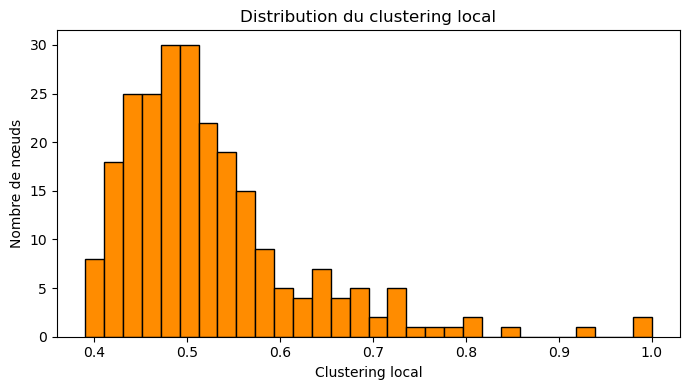

In [10]:
local_clustering = nx.clustering(G)

plt.figure(figsize=(7,4))
plt.hist(local_clustering.values(), bins=30, color='darkorange', edgecolor='black')
plt.xlabel("Clustering local")
plt.ylabel("Nombre de nœuds")
plt.title("Distribution du clustering local")
plt.tight_layout()
plt.show()


Le clustering élevé observé traduit une forte organisation locale des interactions, typiquement à l’intérieur des classes. Cela favorise une propagation rapide au sein d’un même groupe, mais peut ralentir la diffusion inter-classes.

## distance moyenne et diametre

In [11]:
# On travaille sur la composante géante
giant_component = G.subgraph(max(components, key=len))

avg_path_length = nx.average_shortest_path_length(giant_component)
diameter = nx.diameter(giant_component)

print(f"Distance moyenne : {avg_path_length:.2f}")
print(f"Diamètre : {diameter}")


Distance moyenne : 1.73
Diamètre : 3


La faible distance moyenne entre les individus indique un effet petit-monde, suggérant qu’une maladie peut se propager rapidement à travers l’école, même entre élèves appartenant à des classes différentes.

# Analyse des centralités

In [12]:
# DEGREE CENTRALITY
degree_dict = dict(G.degree())

# CLOSENESS
closeness_dict = nx.closeness_centrality(G)

# BETWEENNESS
betweenness_dict = nx.betweenness_centrality(G, weight='weight')

# PAGERANK
pagerank_dict = nx.pagerank(G, weight='weight')

# CENTRALITÉS COMBINÉES DANS UN TABLEAU
import pandas as pd

centralities = pd.DataFrame({
    'node': list(G.nodes()),
    'degree': [degree_dict[n] for n in G.nodes()],
    'closeness': [closeness_dict[n] for n in G.nodes()],
    'betweenness': [betweenness_dict[n] for n in G.nodes()],
    'pagerank': [pagerank_dict[n] for n in G.nodes()],
    'classe': [G.nodes[n].get('classe', 'inconnue') for n in G.nodes()]
})

# Tri des 10 nœuds les plus centraux selon chaque mesure
for metric in ['degree', 'closeness', 'betweenness', 'pagerank']:
    print(f"Top 10 {metric.capitalize()} :")
    display(centralities.sort_values(by=metric, ascending=False).head(10))


Top 10 Degree :


,node,degree,closeness,betweenness,pagerank,classe
42,1551,134,0.692529,0.022330,0.005553,3B
71,1780,129,0.682720,0.008963,0.005722,3A
69,1761,128,0.680791,0.016219,0.004684,1A
57,1673,124,0.673184,0.011289,0.005166,1B
43,1552,123,0.671309,0.017139,0.005961,3B
55,1665,123,0.671309,0.013519,0.007393,1B
99,1579,122,0.669444,0.014008,0.006182,3B
62,1700,121,0.667590,0.009178,0.006710,3B
157,1890,120,0.665746,0.010301,0.007208,2B
64,1708,118,0.662088,0.008876,0.006405,2B


Top 10 Closeness :


,node,degree,closeness,betweenness,pagerank,classe
42,1551,134,0.692529,0.022330,0.005553,3B
71,1780,129,0.682720,0.008963,0.005722,3A
69,1761,128,0.680791,0.016219,0.004684,1A
57,1673,124,0.673184,0.011289,0.005166,1B
43,1552,123,0.671309,0.017139,0.005961,3B
55,1665,123,0.671309,0.013519,0.007393,1B
99,1579,122,0.669444,0.014008,0.006182,3B
62,1700,121,0.667590,0.009178,0.006710,3B
157,1890,120,0.665746,0.010301,0.007208,2B
70,1765,118,0.662088,0.014138,0.005986,1B


Top 10 Betweenness :


,node,degree,closeness,betweenness,pagerank,classe
42,1551,134,0.692529,0.022330,0.005553,3B
43,1552,123,0.671309,0.017139,0.005961,3B
69,1761,128,0.680791,0.016219,0.004684,1A
28,1498,106,0.640957,0.014261,0.005678,5A
70,1765,118,0.662088,0.014138,0.005986,1B
99,1579,122,0.669444,0.014008,0.006182,3B
21,1477,98,0.627604,0.013887,0.005595,5A
55,1665,123,0.671309,0.013519,0.007393,1B
17,1465,61,0.572447,0.012294,0.004287,5B
61,1698,99,0.629243,0.012139,0.007584,1B


Top 10 Pagerank :


,node,degree,closeness,betweenness,pagerank,classe
59,1695,103,0.635884,0.006022,0.007930,1B
100,1697,116,0.658470,0.006683,0.007843,1B
61,1698,99,0.629243,0.012139,0.007584,1B
154,1613,111,0.649596,0.010741,0.007559,2A
55,1665,123,0.671309,0.013519,0.007393,1B
44,1558,101,0.632546,0.008374,0.007382,3B
157,1890,120,0.665746,0.010301,0.007208,2B
8,1437,95,0.622739,0.005335,0.007184,5B
45,1563,97,0.625974,0.008957,0.006944,5B
150,1889,87,0.610127,0.002707,0.006926,2B


C:\Users\david\AppData\Local\Temp\ipykernel_38100\3884366314.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{v*1000:.1f}" for v in xlabels])


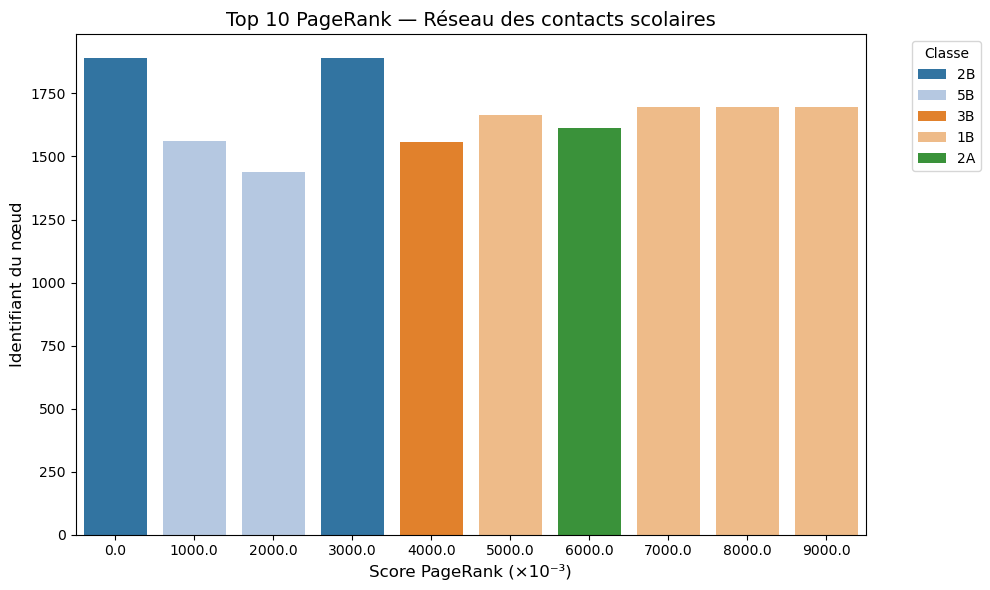

In [14]:
# Top 10 PageRank (ou remplacer par d'autres centralités)
top_pr = centralities.sort_values(by='pagerank', ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top_pr,
    y='node',
    x='pagerank',
    hue='classe',
    dodge=False,
    palette="tab20"
)

# Rendre les valeurs lisibles sur X
ax.set_title("Top 10 PageRank — Réseau des contacts scolaires", fontsize=14)
ax.set_xlabel("Score PageRank (×10⁻³)", fontsize=12)
ax.set_ylabel("Identifiant du nœud", fontsize=12)

# Convertir l'échelle en milliemes pour lisibilité
xlabels = ax.get_xticks()
ax.set_xticklabels([f"{v*1000:.1f}" for v in xlabels])

plt.legend(title="Classe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Closeness

Un nœud avec une closeness élevée est “central géométriquement”. Il peut propager rapidement une infection ou de l’information.

### Betweenness

Ces nœuds font le pont entre des sous-groupes. Ils sont critiques pour le contrôle de la diffusion inter-classe.

### PageRank

Cette mesure prend en compte l’importance des voisins. Un nœud PageRank élevé est souvent connecté à des individus eux-mêmes centraux.

# Détection des communautés

In [15]:
import community as community_louvain
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Détection des communautés
partition = community_louvain.best_partition(G, weight='weight')
modularity = community_louvain.modularity(partition, G, weight='weight')
print(f"Modularité du graphe (Louvain) : {modularity:.4f}")


Modularité du graphe (Louvain) : 0.6727


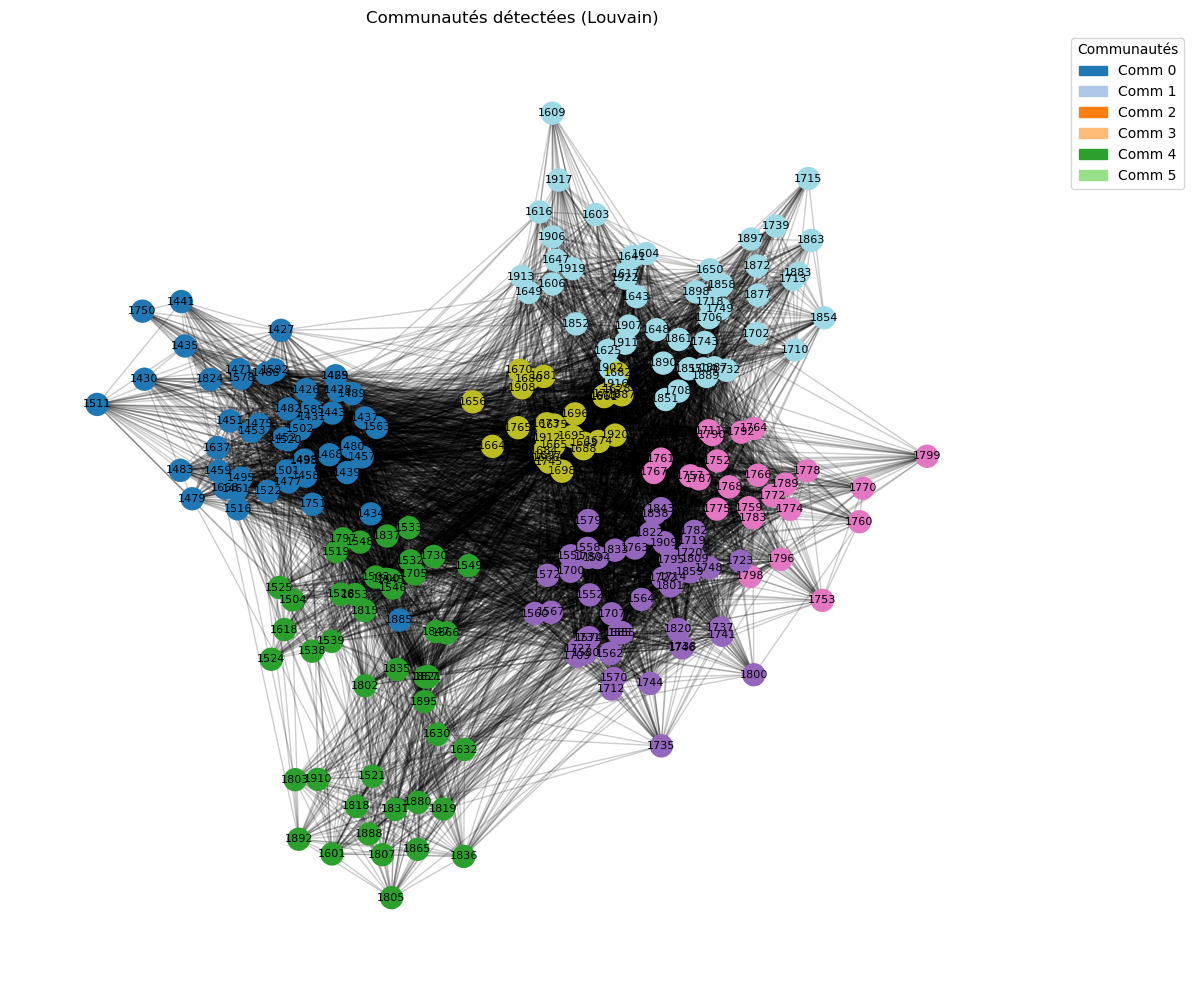

In [16]:
# Position fixe
pos = nx.spring_layout(G, seed=42)

# Couleur par communauté
community_colors = [partition[n] for n in G.nodes()]

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_color=community_colors, cmap=plt.cm.tab20, node_size=250)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Communautés détectées (Louvain)")
plt.axis("off")

# Légende personnalisée
n_communities = len(set(partition.values()))
legend_elements = [Patch(color=plt.cm.tab20(i / 20), label=f"Comm {i}") for i in range(n_communities)]
plt.legend(handles=legend_elements, title="Communautés", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


La modularité obtenue est de **Q = 0.6727**, ce qui indique une structure communautaire nette.
- La plupart des communautés détectées correspondent aux classes administratives (même couleur)
- Quelques communautés sont hybrides, révélant des interactions inter-classes
- Cela valide l’hypothèse que l’école est socialement structurée par classe, mais pas exclusivement

# Simulation Epidémie

### SIR

In [17]:
import random
import networkx as nx

def simulate_sir(G, beta=0.05, gamma=0.1, initial_ratio=0.01, max_steps=50, seed=42):
    random.seed(seed)
    status = {n: 'S' for n in G.nodes()}
    
    # Initialisation : infections aléatoires
    initial_infected = random.sample(list(G.nodes()), int(initial_ratio * len(G)))
    for n in initial_infected:
        status[n] = 'I'

    S, I, R = [len(G.nodes()) - len(initial_infected)], [len(initial_infected)], [0]
    
    for t in range(max_steps):
        new_status = status.copy()
        for node in G.nodes():
            if status[node] == 'I':
                # Transmission à ses voisins S
                for neighbor in G.neighbors(node):
                    if status[neighbor] == 'S':
                        if random.random() < beta:
                            new_status[neighbor] = 'I'
                # Guérison
                if random.random() < gamma:
                    new_status[node] = 'R'
        status = new_status
        counts = list(status.values())
        S.append(counts.count('S'))
        I.append(counts.count('I'))
        R.append(counts.count('R'))
        
        if I[-1] == 0:
            break  # Épidémie terminée
    
    return S, I, R


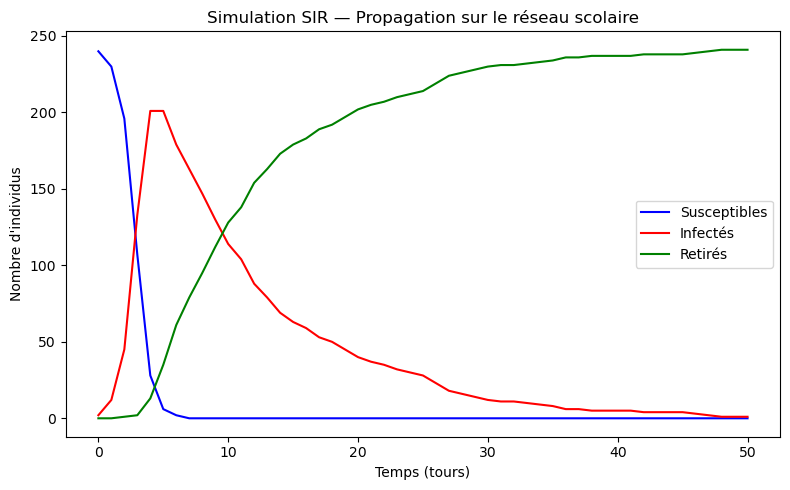

In [18]:
import matplotlib.pyplot as plt

S, I, R = simulate_sir(G, beta=0.05, gamma=0.1, initial_ratio=0.01, max_steps=50)

plt.figure(figsize=(8,5))
plt.plot(S, label='Susceptibles', color='blue')
plt.plot(I, label='Infectés', color='red')
plt.plot(R, label='Retirés', color='green')
plt.xlabel("Temps (tours)")
plt.ylabel("Nombre d'individus")
plt.title("Simulation SIR — Propagation sur le réseau scolaire")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
def run_multiple_sir_simulations(
    G,
    beta=0.05,
    gamma=0.1,
    initial_ratio=0.01,
    n_runs=500,
    threshold_ratio=0.1,
    seed=42
):
    import numpy as np
    random.seed(seed)
    infected_counts = []
    epidemic_flags = []

    for i in range(n_runs):
        S, I, R = simulate_sir(
            G,
            beta=beta,
            gamma=gamma,
            initial_ratio=initial_ratio,
            seed=seed + i  # différent à chaque run
        )
        total_infected = R[-1]  # Nombre total d’infectés
        infected_counts.append(total_infected)
        epidemic_flags.append(total_infected > threshold_ratio * G.number_of_nodes())

    return np.array(infected_counts), np.array(epidemic_flags)


In [20]:
infected_counts, epidemic_flags = run_multiple_sir_simulations(
    G, beta=0.05, gamma=0.1, initial_ratio=0.01, n_runs=500, threshold_ratio=0.1
)

# Statistiques
mean_final = infected_counts.mean()
std_final = infected_counts.std()
epidemic_rate = epidemic_flags.mean() * 100

print(f"🔬 Moyenne d’infectés : {mean_final:.2f} ± {std_final:.2f}")
print(f"⚠️ Pourcentage d’épidémies >10% : {epidemic_rate:.1f}%")


🔬 Moyenne d’infectés : 240.04 ± 1.35
⚠️ Pourcentage d’épidémies >10% : 100.0%


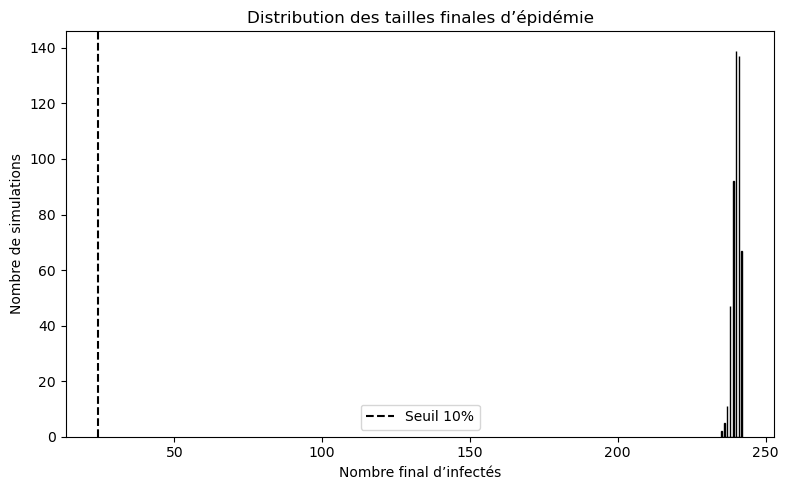

In [21]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.histplot(infected_counts, bins=30, kde=False, color='crimson')
plt.axvline(x=G.number_of_nodes() * 0.1, color='black', linestyle='--', label="Seuil 10%")
plt.xlabel("Nombre final d’infectés")
plt.ylabel("Nombre de simulations")
plt.title("Distribution des tailles finales d’épidémie")
plt.legend()
plt.tight_layout()
plt.show()


Ces résultats indiquent que **dans 100 % des cas, l’épidémie s’est propagée à l’échelle de l’école entière**, atteignant toujours une part significative de la population.  
Le faible écart-type montre une **forte stabilité du scénario**, probablement liée à la **très haute connectivité de la composante géante du graphe** et au **caractère centralisé de certains individus**.

Ce comportement épidémique confirme que, dans l’état actuel du réseau et sans stratégie de mitigation, **l’école constitue un environnement extrêmement favorable à la diffusion** d’une infection.

# Stratégie de fermeture ciblées

📊 Moyenne infectés : 0.85 ± 0.98
🔒 Jours de classe perdus : 8725.1 ± 3386.2
⚠️ Taux d’épidémies >10% : 0.0%


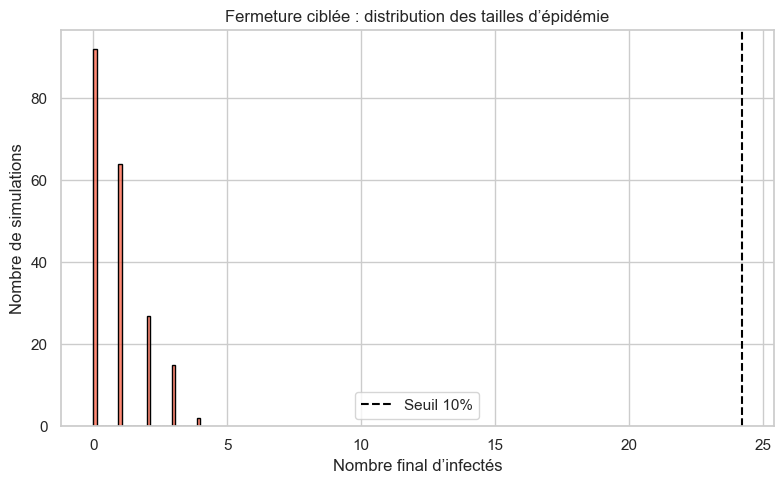

In [23]:
# Projet : Simulation SIR avec stratégie de fermeture ciblée (classe)

import networkx as nx
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import numpy as np

# --- Simulation SIR avec fermeture de classe si >= 2 infectés ---
def simulate_sir_with_class_closure(G, beta=0.05, gamma=0.1, initial_ratio=0.01,
                                     threshold_infected=2, closure_duration=10, max_steps=50, seed=42):
    random.seed(seed)
    status = {n: 'S' for n in G.nodes()}
    node_classes = nx.get_node_attributes(G, 'classe')
    classes = set(node_classes.values())

    # Infection initiale
    initial_infected = random.sample(list(G.nodes()), int(initial_ratio * len(G)))
    for n in initial_infected:
        status[n] = 'I'

    # Suivi de fermeture des classes
    class_closure_timer = {cls: 0 for cls in classes}

    S, I, R = [len(G.nodes()) - len(initial_infected)], [len(initial_infected)], [0]
    total_closed_days = 0

    for t in range(max_steps):
        new_status = status.copy()

        # Compter les infectés par classe
        infected_per_class = defaultdict(int)
        for n, s in status.items():
            if s == 'I':
                cls = node_classes.get(n)
                if cls:
                    infected_per_class[cls] += 1

        # Déclencher la fermeture
        for cls, count in infected_per_class.items():
            if count >= threshold_infected and class_closure_timer[cls] == 0:
                class_closure_timer[cls] = closure_duration

        # Appliquer la fermeture : on désactive les nœuds concernés
        active_nodes = [n for n in G.nodes() if class_closure_timer.get(node_classes.get(n), 0) == 0]

        # Simulation SIR
        for node in active_nodes:
            if status[node] == 'I':
                for neighbor in G.neighbors(node):
                    if status[neighbor] == 'S' and neighbor in active_nodes:
                        if random.random() < beta:
                            new_status[neighbor] = 'I'
                if random.random() < gamma:
                    new_status[node] = 'R'

        status = new_status

        # Mise à jour des fermetures
        for cls in class_closure_timer:
            if class_closure_timer[cls] > 0:
                total_closed_days += list(node_classes.values()).count(cls)
                class_closure_timer[cls] -= 1

        # Compter les statuts
        vals = list(status.values())
        S.append(vals.count('S'))
        I.append(vals.count('I'))
        R.append(vals.count('R'))

        if I[-1] == 0:
            break

    return S, I, R, total_closed_days

# --- Simulation multiple avec stratégie de fermeture ---
def run_sir_closure_simulations(G, beta=0.05, gamma=0.1, n_runs=100, threshold_ratio=0.1):
    infected_counts = []
    closed_days_list = []
    epidemic_flags = []
    for i in range(n_runs):
        S, I, R, closed = simulate_sir_with_class_closure(G, beta=beta, gamma=gamma, seed=100+i)
        infected_counts.append(R[-1])
        closed_days_list.append(closed)
        epidemic_flags.append(R[-1] > threshold_ratio * G.number_of_nodes())

    return np.array(infected_counts), np.array(closed_days_list), np.array(epidemic_flags)

# --- Exécution exemple ---
infected_c, closed_c, epi_c = run_sir_closure_simulations(G, beta=0.05, gamma=0.1, n_runs=200)

print(f"📊 Moyenne infectés : {infected_c.mean():.2f} ± {infected_c.std():.2f}")
print(f"🔒 Jours de classe perdus : {closed_c.mean():.1f} ± {closed_c.std():.1f}")
print(f"⚠️ Taux d’épidémies >10% : {epi_c.mean()*100:.1f}%")

# --- Visualisation des tailles finales d’épidémie ---
plt.figure(figsize=(8,5))
sns.histplot(infected_c, bins=30, color='tomato', edgecolor='black')
plt.axvline(x=G.number_of_nodes()*0.1, color='black', linestyle='--', label='Seuil 10%')
plt.xlabel("Nombre final d’infectés")
plt.ylabel("Nombre de simulations")
plt.title("Fermeture ciblée : distribution des tailles d’épidémie")
plt.legend()
plt.tight_layout()
plt.show()


# randomw walk

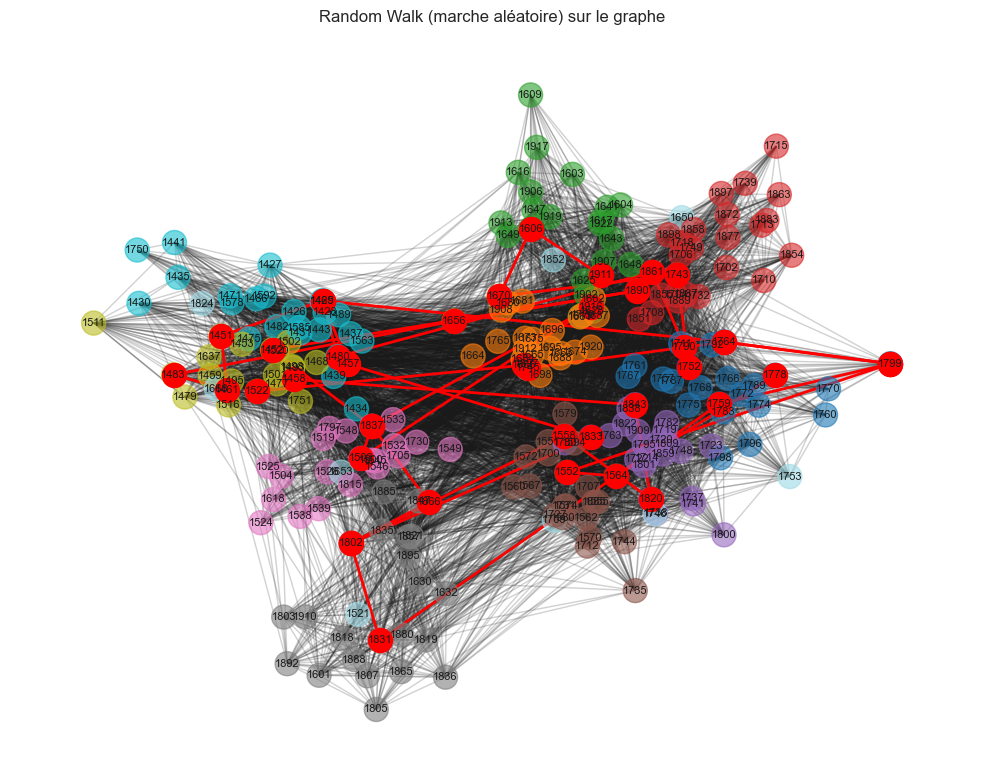

In [25]:
# Projet : Simulation SIR avec stratégie de fermeture ciblée (classe)

import networkx as nx
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import numpy as np


# --- Random Walk simple et visualisation ---
def run_random_walk(G, start_node=None, steps=30, seed=42):
    random.seed(seed)
    if not start_node:
        start_node = random.choice(list(G.nodes()))
    path = [start_node]
    for _ in range(steps):
        neighbors = list(G.neighbors(path[-1]))
        if not neighbors:
            break
        next_node = random.choice(neighbors)
        path.append(next_node)
    return path

# --- Affichage de la marche aléatoire ---
def plot_random_walk(G, path):
    pos = nx.spring_layout(G, seed=42)
    classes = nx.get_node_attributes(G, 'classe')
    color_map = {cls: i for i, cls in enumerate(sorted(set(classes.values())))}
    node_colors = [color_map[classes.get(n, 'x')] for n in G.nodes()]

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab20, node_size=300, alpha=0.6)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    nx.draw_networkx_labels(G, pos, font_size=8)

    # Highlight the random walk
    edge_path = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=edge_path, edge_color='red', width=2)
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='red', node_size=300)

    plt.title("Random Walk (marche aléatoire) sur le graphe")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Exemple d'exécution
walk_path = run_random_walk(G, steps=40)
plot_random_walk(G, walk_path)

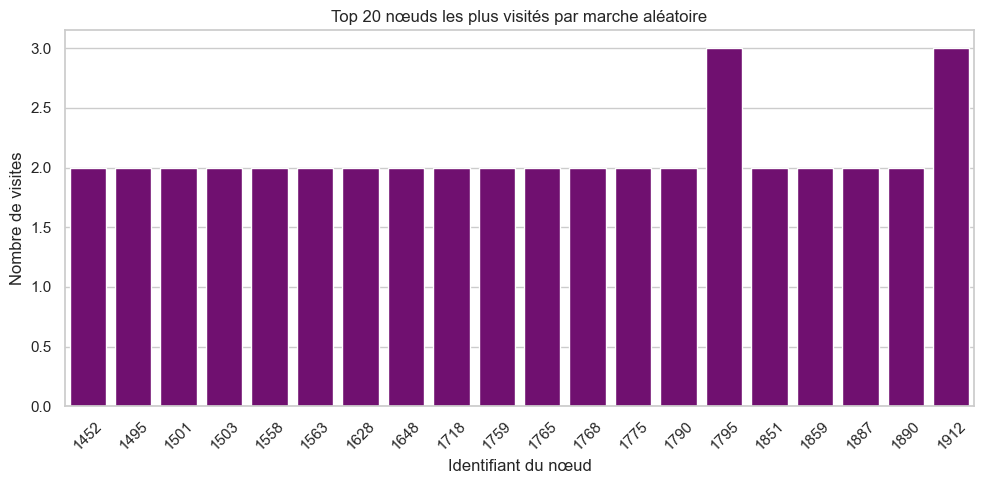

In [28]:

# --- Random Walk fréquentielle : centralité empirique ---
def estimate_visit_frequencies(G, n_walks=1000, steps=100, seed=123):
    visit_counter = defaultdict(int)
    random.seed(seed)
    for i in range(n_walks):
        path = run_random_walk(G, steps=steps, seed=seed + i)
    for node in path:
        visit_counter[node] += 1
    return visit_counter


# --- Visualisation des fréquences de visite ---
visit_freqs = estimate_visit_frequencies(G, n_walks=1000, steps=100)


# Construction du DataFrame pour affichage
freq_df = pd.DataFrame.from_dict(visit_freqs, orient='index', columns=['visits'])
freq_df = freq_df.sort_values(by='visits', ascending=False)


plt.figure(figsize=(10,5))
sns.barplot(x=freq_df.index[:20], y=freq_df.visits[:20], color='purple')
plt.xticks(rotation=45)
plt.title("Top 20 nœuds les plus visités par marche aléatoire")
plt.xlabel("Identifiant du nœud")
plt.ylabel("Nombre de visites")
plt.tight_layout()
plt.show()

### markov

In [42]:
def compute_stationary_distribution(G):
    P = transition_matrix(G)
    eigenvalues, eigenvectors = np.linalg.eig(P.T)

    # Identifier l'indice du vecteur propre correspondant à l'autoval λ ≈ 1
    idx = np.argmax(np.isclose(eigenvalues, 1.0))
    v = eigenvectors[:, idx].real

    # Nettoyage : éviter les valeurs négatives ou NaN
    v = np.abs(v)
    if v.sum() == 0:
        raise ValueError("Le vecteur stationnaire est nul. Vérifier la matrice de transition.")
    return v / v.sum()


In [44]:
stationary = compute_stationary_distribution(G)

plt.figure(figsize=(8, 4))
plt.bar(range(len(stationary)), stationary)
plt.title("Distribution stationnaire — chaîne de Markov sur le graphe")
plt.xlabel("ID de nœud")
plt.ylabel("Probabilité limite")
plt.tight_layout()
plt.show()


ValueError: Le vecteur stationnaire est nul. Vérifier la matrice de transition.

In [45]:
def exact_stationary_distribution_degree(G):
    degree_dict = dict(G.degree())
    total_degree = sum(degree_dict.values())
    return {n: d / total_degree for n, d in degree_dict.items()}


<Figure size 1000x400 with 0 Axes>

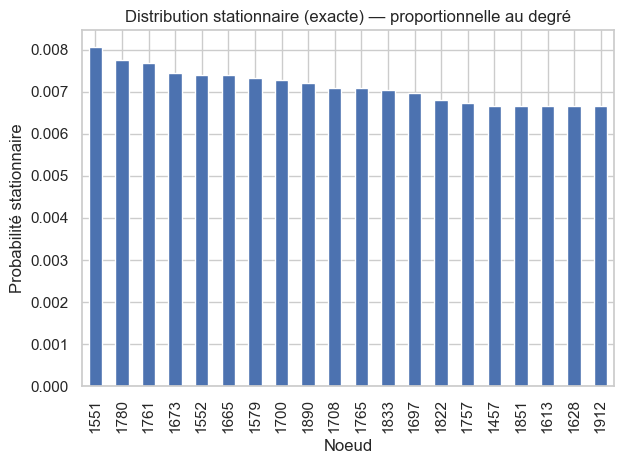

In [46]:
stationary_deg = exact_stationary_distribution_degree(G)
df_stat = pd.DataFrame.from_dict(stationary_deg, orient='index', columns=['proba'])

plt.figure(figsize=(10, 4))
df_stat.sort_values('proba', ascending=False).head(20).plot(kind='bar', legend=False)
plt.title("Distribution stationnaire (exacte) — proportionnelle au degré")
plt.ylabel("Probabilité stationnaire")
plt.xlabel("Noeud")
plt.tight_layout()
plt.show()


# Laplacien spectral

Valeur de Fiedler (λ₂) : 0.0732


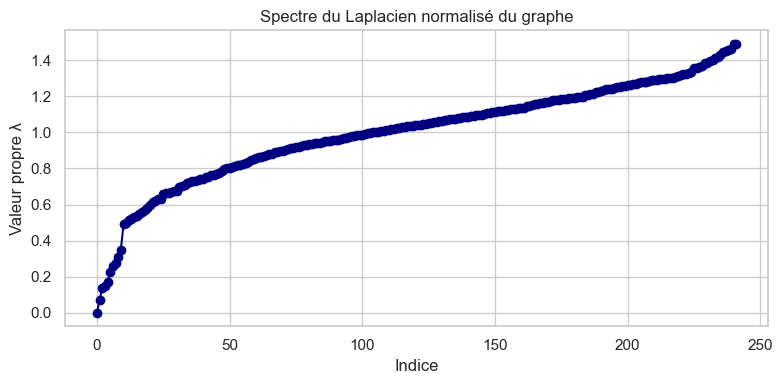

In [32]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import numpy as np


# --- Analyse spectrale du Laplacien ---
def analyze_laplacian_spectrum(G):
    spectrum = nx.normalized_laplacian_spectrum(G)
    spectrum = sorted(spectrum)
    lambda_2 = spectrum[1] # Fiedler value
    print(f"Valeur de Fiedler (λ₂) : {lambda_2:.4f}")


# Visualisation du spectre
    plt.figure(figsize=(8, 4))
    plt.plot(spectrum, marker='o', linestyle='-', color='navy')
    plt.title("Spectre du Laplacien normalisé du graphe")
    plt.xlabel("Indice")
    plt.ylabel("Valeur propre λ")
    plt.tight_layout()
    plt.show()


# Appel de la fonction d'analyse
analyze_laplacian_spectrum(G)


# --- Simulation SIR avec fermeture de classe si >= 2 infectés ---
def simulate_sir_with_class_closure(G, beta=0.05, gamma=0.1, initial_ratio=0.01,
threshold_infected=2, closure_duration=10, max_steps=50, seed=42):
    random.seed(seed)
    status = {n: 'S' for n in G.nodes()}
    node_classes = nx.get_node_attributes(G, 'classe')
    classes = set(node_classes.values())


    # Infection initiale
    initial_infected = random.sample(list(G.nodes()), int(initial_ratio * len(G)))
    for n in initial_infected:
        status[n] = 'I'


    # Suivi de fermeture des classes
    class_closure_timer = {cls: 0 for cls in classes}


    S, I, R = [len(G.nodes()) - len(initial_infected)], [len(initial_infected)], [0]
    total_closed_days = 0


    for t in range(max_steps):
        new_status = status.copy()


        # Compter les infectés par classe
        infected_per_class = defaultdict(int)
        for n, s in status.items():
            if s == 'I':
                cls = node_classes.get(n)
            if cls:
                infected_per_class[cls] += 1


        # Déclencher la fermeture
        for cls, count in infected_per_class.items():
            if count >= threshold_infected and class_closure_timer[cls] == 0:
                class_closure_timer[cls] = closure_duration


        # Appliquer la fermeture : on désactive les nœuds concernés
        active_nodes = [n for n in G.nodes() if class_closure_timer.get(node_classes.get(n), 0) == 0]


        # Simulation SIR
        for node in active_nodes:
            if status[node] == 'I':
                for neighbor in G.neighbors(node):
                    if status[neighbor] == 'S' and neighbor in active_nodes:
                        if random.random() < beta:
                            new_status[neighbor] = 'I'
                if random.random() < gamma:
                    new_status[node] = 'R'


        status = new_status


        # Mise à jour des fermetures
        for cls in class_closure_timer:
            if class_closure_timer[cls] > 0:
                total_closed_days += list(node_classes.values()).count(cls)
                class_closure_timer[cls] -= 1


        # Compter les statuts
        vals = list(status.values())
        S.append(vals.count('S'))
        I.append(vals.count('I'))
        R.append(vals.count('R'))


        if I[-1] == 0:
            break


    return S, I, R, total_closed_days

L’analyse du spectre du Laplacien normalisé montre que la deuxième plus petite valeur propre (valeur de Fiedler) est :

**λ₂ = 0.0732**

Cette valeur faible indique que le graphe présente une **faible connectivité globale**, typique d’une **structure modulaire** : les classes scolaires apparaissent comme des **sous-groupes faiblement reliés entre eux**.

Cette structure modulaire a des implications importantes pour la dynamique sur le graphe :
- Une infection peut **se propager rapidement dans une classe**
- Mais elle aura **du mal à franchir les frontières inter-classes**, sauf via quelques ponts (enseignants, lieux communs)

Cela justifie le **bon effet des stratégies de fermeture ciblée**, et explique pourquoi les random walks et les épidémies **restent souvent confinés localement**.

# Comparaison graphe aléatoire

In [35]:
def compute_fiedler_value(G):
    spectrum = nx.normalized_laplacian_spectrum(G)
    spectrum = sorted(spectrum)
    return spectrum[1]  # λ₂

def compare_with_random_graph(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    p = 2 * m / (n * (n - 1))  # même densité

    G_er = nx.gnp_random_graph(n, p, seed=42)

    # Valeurs de Fiedler
    lambda2_real = compute_fiedler_value(G)
    lambda2_er = compute_fiedler_value(G_er)

    # Clustering
    clustering_real = nx.average_clustering(G)
    clustering_er = nx.average_clustering(G_er)

    # Distance moyenne (sur composante géante)
    if nx.is_connected(G):
        dist_real = nx.average_shortest_path_length(G)
    else:
        giant_real = G.subgraph(max(nx.connected_components(G), key=len))
        dist_real = nx.average_shortest_path_length(giant_real)

    if nx.is_connected(G_er):
        dist_er = nx.average_shortest_path_length(G_er)
    else:
        giant_er = G_er.subgraph(max(nx.connected_components(G_er), key=len))
        dist_er = nx.average_shortest_path_length(giant_er)

    # Affichage
    print("\n🔍 Comparaison avec graphe Erdős–Rényi")
    print(f"- Valeur de Fiedler réelle (λ₂) : {lambda2_real:.4f}")
    print(f"- Valeur de Fiedler ER           : {lambda2_er:.4f}")
    print(f"- Clustering réel                : {clustering_real:.4f}")
    print(f"- Clustering ER                  : {clustering_er:.4f}")
    print(f"- Distance moyenne réelle        : {dist_real:.2f}")
    print(f"- Distance moyenne ER            : {dist_er:.2f}")
    
compare_with_random_graph(G)



🔍 Comparaison avec graphe Erdős–Rényi
- Valeur de Fiedler réelle (λ₂) : 0.0732
- Valeur de Fiedler ER           : 0.8039
- Clustering réel                : 0.5255
- Clustering ER                  : 0.2850
- Distance moyenne réelle        : 1.73
- Distance moyenne ER            : 1.72


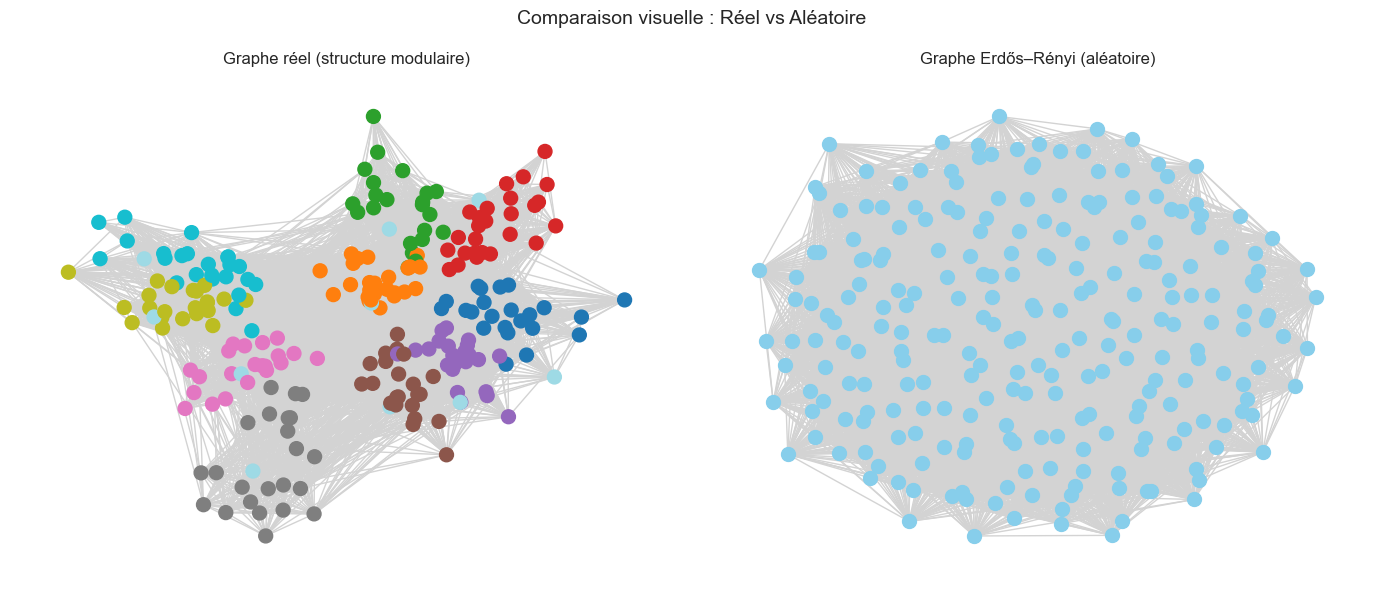

In [36]:
# Projet : Simulation SIR avec stratégie de fermeture ciblée (classe)

import networkx as nx
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import numpy as np

# --- Visualisation côte à côte : graphe réel vs Erdős–Rényi ---
def plot_real_vs_er_graphs(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    p = 2 * m / (n * (n - 1))

    G_er = nx.gnp_random_graph(n, p, seed=42)

    pos = nx.spring_layout(G, seed=42)

    # Graphe réel avec couleurs de classe
    classes = nx.get_node_attributes(G, 'classe')
    color_map = {cls: i for i, cls in enumerate(sorted(set(classes.values())))}
    node_colors = [color_map[classes.get(n, 'x')] for n in G.nodes()]

    plt.figure(figsize=(14, 6))

    # Graphe réel
    plt.subplot(1, 2, 1)
    nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.tab20, with_labels=False, node_size=100, edge_color="lightgray")
    plt.title("Graphe réel (structure modulaire)")
    plt.axis('off')

    # Graphe ER (aléatoire)
    plt.subplot(1, 2, 2)
    pos_er = nx.spring_layout(G_er, seed=42)
    nx.draw(G_er, pos_er, node_color='skyblue', with_labels=False, node_size=100, edge_color="lightgray")
    plt.title("Graphe Erdős–Rényi (aléatoire)")
    plt.axis('off')

    plt.suptitle("Comparaison visuelle : Réel vs Aléatoire", fontsize=14)
    plt.tight_layout()
    plt.show()

# Appel de la fonction
plot_real_vs_er_graphs(G)
